
- Applying model and Gridsearch


In [34]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow_addons.metrics import RSquare
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dropout

In [37]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)

In [38]:
with open("data/full_features/full-feature-tf/traindt.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/full-feature-tf/testdt.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)
with open("data/full_features/testdt_not_tf.pkl", 'rb') as f:
   _, ytest_df =  pickle.load(file = f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/full_features/full-feature-tf/traindt.pkl'

In [ ]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, ytest_df.shape

((738, 174), (104, 174), (738,), (104,), (104, 1))

Set up experiment, Spliting data


In [ ]:
import logging
import random
logging.getLogger('tensorflow').disabled = True 
seed = 12345

In [ ]:
# spliting data to visualize chosen networks
random.seed(seed)
xtrain_, xval_, ytrain_, yval_ = train_test_split(xtrain, ytrain, test_size=0.20, random_state=42)

In [ ]:
xval_.shape, yval_.shape

((148, 174), (148,))

In [ ]:
xtrain_.shape, ytrain_.shape

((590, 174), (590,))

Get measure functions, summary Grid results


In [ ]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

## Model implementation


### Neural Networks


In [ ]:
# Building plot function 

def plot_history(model_hist, expname, epochs =200):
    res = pd.DataFrame(model_hist.history)
    res_dic = {'loss - MSE':{'train':res['loss'], 'val':res['val_loss']},
                'r2': {'train':res['r_square'], 'val':res['val_r_square']}}
    x = range(1, epochs+1)
    fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
    measures = list(res_dic.keys())
    for i, m in enumerate(measures):
        ax[i].plot(x, res_dic[m]['train'], label = f'training{m}')
        ax[i].plot(x, res_dic[m]['val'], label = f'training{m}')
        ax[i].set_ylabel(measures[i])   
        ax[i].set_title(f'Training and validation {m} {expname}')
        ax[i].legend(['training', 'validation'])
        ax[i].grid(visible=True)
    plt.xlabel('Epochs')
    plt.show()

In [ ]:
#plot comparation

def plot_comparation(data_list, label_list, title, ylabel, epochrange):
    epochs = range(epochrange[0]+1, epochrange[1]+1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data[epochrange[0]: epochrange[1]], label=label)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [ ]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [ ]:
def get_best_epochs(model_hist):
   model_loss = model_hist.history["val_loss"]
   epoch_chosen = model_loss.index(min(model_loss)) +1
   print(f'Best number of epochs {epoch_chosen}')

In [ ]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true[i] == 0:
            if abs(true[i]-pred[i]) <= 3: # 
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

MLP


In [ ]:
# Finding the best Number of hidden layers
mlp_gridlayers = {'hidden_layer_sizes': [(64, 8),
                                         (64, 16, 8),
                                         (128, 16, 8),
                                         (128, 32, 8),
                                         (128, 64, 8),
                                         (128, 64, 16),
                                         (128, 64, 16, 8),
                                         (256, 128, 16, 8),
                                         (256, 128, 32, 8),
                                         (256, 128, 64, 8),
                                         (256, 128, 64, 16),
                                         (256, 128, 64, 32),
                                         (128, 128, 128, 64, 16),
                                         (256, 128, 128, 64, 8),
                                         (256, 256, 128, 128, 64),
                                         (256, 128, 64, 16, 8),
                                         (256, 128, 64, 32, 8),
                                         (256, 128, 64, 32, 16),
                                         (256, 128, 64, 64, 8),
                                         (256, 128, 64, 64, 16),
                                         (256, 128, 64, 32, 16, 8),]}

random.seed(seed)
mlp = MLPRegressor(max_iter=200, early_stopping=True)  # default by the rest
grid_layers = GridSearchCV(mlp, mlp_gridlayers, cv=4,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_result_layer = grid_layers.fit(xtrain, ytrain)
summaryGridresult(grid_result_layer, 'Best results for Hidden layers structures', 10)

Best results for Hidden layers structures
Best: 0.631237 using {'hidden_layer_sizes': (256, 128, 64, 64, 16)}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
19,"{'hidden_layer_sizes': (256, 128, 64, 64, 16)}",0.774292,0.027989,0.631237,0.027989
9,"{'hidden_layer_sizes': (256, 128, 64, 8)}",0.819893,0.025705,0.618255,0.025705
7,"{'hidden_layer_sizes': (256, 128, 16, 8)}",0.779404,0.032946,0.617579,0.032946
14,"{'hidden_layer_sizes': (256, 256, 128, 128, 64)}",0.821738,0.024638,0.613030,0.024638
13,"{'hidden_layer_sizes': (256, 128, 128, 64, 8)}",0.773800,0.028977,0.612727,0.028977
11,"{'hidden_layer_sizes': (256, 128, 64, 32)}",0.781048,0.045998,0.607092,0.045998
15,"{'hidden_layer_sizes': (256, 128, 64, 16, 8)}",0.783474,0.048201,0.606247,0.048201
16,"{'hidden_layer_sizes': (256, 128, 64, 32, 8)}",0.778628,0.039619,0.606000,0.039619
20,"{'hidden_layer_sizes': (256, 128, 64, 32, 16, 8)}",0.828118,0.031424,0.599190,0.031424
8,"{'hidden_layer_sizes': (256, 128, 32, 8)}",0.776498,0.044249,0.596656,0.044249


In [ ]:
# Build baseline network with Keras
#network = [256, 128, 64, 16, 8]
#kernel_init = 'uniform'
#acti = 'relu'
#opt = 'adam'
n_feat = xtrain.shape[1]
chosenNetwork = grid_result_layer.best_params_['hidden_layer_sizes']
def create_mlpbl():
   network =chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = 'uniform', 
                  activation='relu' , input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model
#network = np.array([256, 128, 64, 16])
mlpbl = create_mlpbl()
mlpbl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               44800     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 91,169
Trainable params: 91,169
Non-traina

In [ ]:
tf.random.set_seed(seed)
random.seed(seed)
mlpbl = create_mlpbl()
mlpbl_hist = mlpbl.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=128,
                      validation_data=(xval_, yval_),
                      verbose=0)

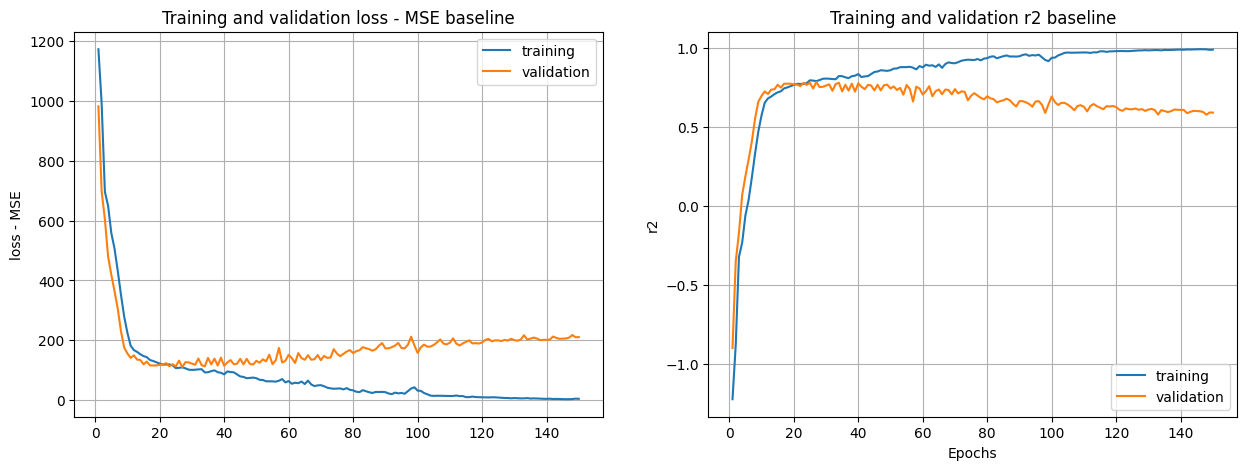

In [ ]:
plot_history(mlpbl_hist,'baseline',150)

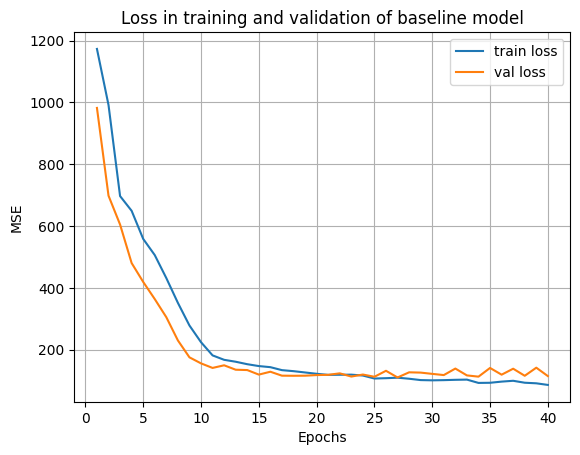

In [ ]:
loss_train = mlpbl_hist.history['loss']
loss_val = mlpbl_hist.history['val_loss']


plot_comparation(data_list=[loss_train,loss_val], 
               label_list=['train loss', 'val loss'],
               title='Loss in training and validation of baseline model',
               ylabel='MSE',
               epochrange=(0,40))

In [ ]:
get_best_epochs(mlpbl_hist)

Best number of epochs 27


### choose batch size

In [ ]:
# default params as baseline

# Grid params
batch_size = np.array([8, 16, 32, 64, 128])
epochs = np.arange(0,30)
batch_pams = dict(batch_size=batch_size, epochs=epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)

mlp = KerasRegressor(model=create_mlpbl, verbose=0)
grid_batch = GridSearchCV(mlp, batch_pams, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_batch = grid_batch.fit(xtrain, ytrain)
summaryGridresult(grid_result_batch, 'Top batch-sizes by ep/ochs', 10)


c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top batch-sizes by ep/ochs
Best: 0.645630 using {'batch_size': 16, 'epochs': 11}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
41,"{'batch_size': 16, 'epochs': 11}",0.796421,0.027405,0.645630,0.027405
105,"{'batch_size': 64, 'epochs': 15}",0.785421,0.024903,0.644742,0.024903
40,"{'batch_size': 16, 'epochs': 10}",0.794300,0.029048,0.644537,0.029048
70,"{'batch_size': 32, 'epochs': 10}",0.762767,0.027684,0.642207,0.027684
80,"{'batch_size': 32, 'epochs': 20}",0.817908,0.016770,0.642170,0.016770
145,"{'batch_size': 128, 'epochs': 25}",0.796463,0.017818,0.637423,0.017818
12,"{'batch_size': 8, 'epochs': 12}",0.808567,0.028679,0.637269,0.028679
77,"{'batch_size': 32, 'epochs': 17}",0.792406,0.015400,0.636001,0.015400
38,"{'batch_size': 16, 'epochs': 8}",0.760449,0.009334,0.634334,0.009334
109,"{'batch_size': 64, 'epochs': 19}",0.803218,0.028179,0.632223,0.028179


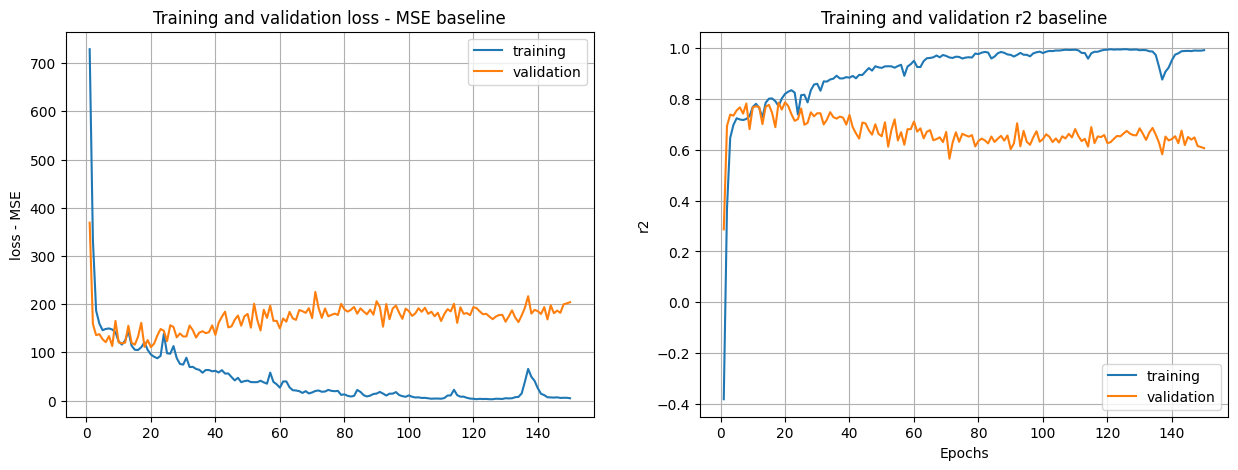

In [ ]:
chosenBatch = grid_result_batch.best_params_['batch_size']
tf.random.set_seed(seed)
random.seed(seed)
mlp = create_mlpbl()
mlpbl_hist = mlp.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlpbl_hist,'baseline',150)

In [ ]:
get_best_epochs(mlpbl_hist)

Best number of epochs 20


### Kernel initializer

In [ ]:
### Kernel initializer

def create_mlpk(k_init = 'uniform'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = k_init, 
                  activation='relu', input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
k_init = ['uniform', 'normal', 'glorot_normal', 'glorot_uniform',]
epochs = np.arange(0,30)

pams_grid = dict(model__k_init= k_init,  
               epochs = epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)
mlp = KerasRegressor(model = create_mlpk,
                     batch_size = chosenBatch,
                     verbose=0)
grid_kn = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_kn = grid_kn.fit(xtrain, ytrain)


pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_kn, 'Top results for inititalization' , 10)


Top results for inititalization
Best: 0.652943 using {'epochs': 8, 'model__k_init': 'glorot_normal'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
34,"{'epochs': 8, 'model__k_init': 'glorot_normal'}",0.772592,0.017020,0.652943,0.017020
53,"{'epochs': 13, 'model__k_init': 'normal'}",0.833989,0.018822,0.641369,0.018822
55,"{'epochs': 13, 'model__k_init': 'glorot_uniform'}",0.824428,0.028786,0.640178,0.028786
58,"{'epochs': 14, 'model__k_init': 'glorot_normal'}",0.824943,0.033526,0.639120,0.033526
38,"{'epochs': 9, 'model__k_init': 'glorot_normal'}",0.803777,0.017896,0.639072,0.017896
50,"{'epochs': 12, 'model__k_init': 'glorot_normal'}",0.833009,0.030410,0.636807,0.030410
61,"{'epochs': 15, 'model__k_init': 'normal'}",0.841078,0.021740,0.636784,0.021740
35,"{'epochs': 8, 'model__k_init': 'glorot_uniform'}",0.796933,0.032832,0.635883,0.032832
68,"{'epochs': 17, 'model__k_init': 'uniform'}",0.820610,0.036947,0.635629,0.036947
30,"{'epochs': 7, 'model__k_init': 'glorot_normal'}",0.783721,0.041949,0.634512,0.041949


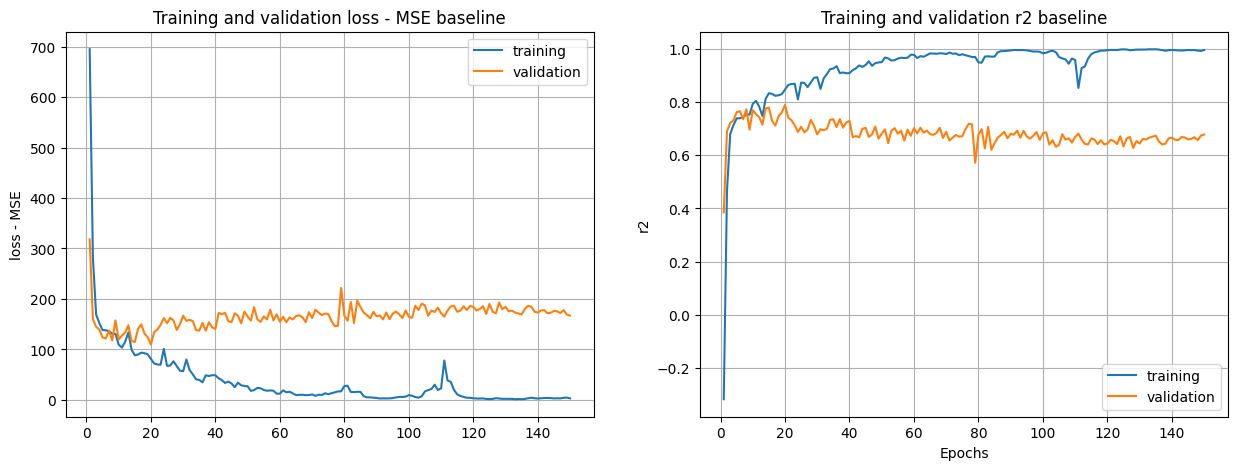

In [ ]:
chosenKn = grid_result_kn.best_params_['model__k_init']
tf.random.set_seed(seed)
random.seed(seed)
mlp_kn = create_mlpk(chosenKn)
mlp_kn_hist = mlp_kn.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_kn_hist,'baseline',150)

In [ ]:
get_best_epochs(mlp_kn_hist)

Best number of epochs 20


### activation funtion

In [ ]:
# model default params for assessing activation and kernel initialization
# network = [256, 128, 64, 16, 8]
# batch size = 128
# opt = 'adam'

def create_mlpa(acti = 'relu'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=acti, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = acti))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
acti = ['relu','selu','elu', 'tanh', 'sigmoid']
epochs = np.arange(0,30)

pams_grid = dict(model__acti = acti, 
               epochs = epochs)

# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlpa,
                     batch_size = chosenBatch,
                     verbose=0)
grid_a = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_a = grid_a.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_a, 'Top results for activation' , 10)

Top results for activation
Best: 0.637241 using {'epochs': 17, 'model__acti': 'relu'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
85,"{'epochs': 17, 'model__acti': 'relu'}",0.845625,0.026148,0.637241,0.026148
62,"{'epochs': 12, 'model__acti': 'elu'}",0.801845,0.037569,0.634071,0.037569
92,"{'epochs': 18, 'model__acti': 'elu'}",0.827767,0.031535,0.633513,0.031535
51,"{'epochs': 10, 'model__acti': 'selu'}",0.801488,0.036945,0.630837,0.036945
45,"{'epochs': 9, 'model__acti': 'relu'}",0.807246,0.044399,0.629275,0.044399
47,"{'epochs': 9, 'model__acti': 'elu'}",0.778191,0.022662,0.626948,0.022662
65,"{'epochs': 13, 'model__acti': 'relu'}",0.819035,0.023739,0.626854,0.023739
87,"{'epochs': 17, 'model__acti': 'elu'}",0.830433,0.032126,0.626565,0.032126
82,"{'epochs': 16, 'model__acti': 'elu'}",0.811546,0.034539,0.626194,0.034539
71,"{'epochs': 14, 'model__acti': 'selu'}",0.826474,0.018055,0.625206,0.018055


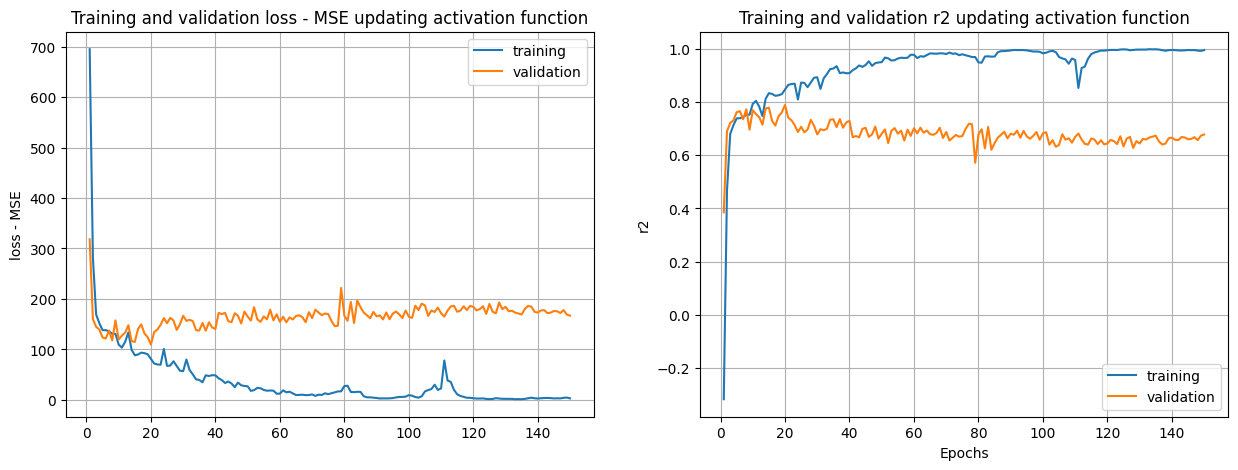

In [ ]:
chosenActi = grid_result_a.best_params_['model__acti']
tf.random.set_seed(seed)
random.seed(seed)
mlp_a = create_mlpa(chosenActi)
mlp_a_hist = mlp_a.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_a_hist,'updating activation function',150)

In [ ]:
get_best_epochs(mlp_a_hist)

Best number of epochs 20


### Selecting optimizer

In [39]:
# model default params for assessing optimization
# network = [256, 128, 64, 16]
# batch size = 128
# acti = 'selu' / kernel_init = 'uniform' 
def create_mlpopt(opt = 'Adam'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
opt = ['SGD', 'RMSprop', 'Adam']
epochs = np.arange(0,30)
pams_grid = dict(model__opt =opt, 
                  epochs = epochs)

# Build model and grid searcg
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpopt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_opt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_opt = grid_opt.fit(xtrain, ytrain)
summaryGridresult(grid_result_opt, 'Top resutls for optimizer' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.56425332 -1.55979633 -1.55707085         nan  0.19082242 -1.06738999
         nan  0.51512416  0.3938955          nan  0.57887158  0.57132533
         nan  0.576341    0.51292503         nan  0.6098644   0.57348562
         nan  0.63607015  0.58132719         nan  0.59112179  0.61726923
         nan  0.49096619  0.54275864         nan  0.6279401   0.61241335
         nan  0.58378489  0.64206884         nan  0.60043737  0.63015021
         nan  0.63629602  0.6283669          nan  0.54962106  0.64376102
         nan  0.60040673  0.53358634         nan  0.26816045  0.6322433
         nan  0.4855768   0.61532376         nan  0.42691107  0.52856059
         nan  0.5881481   0.5912569          nan  0.61340356  0.44836735
         nan  0.45081528  0.56456361         nan  0.61049657  0.61489082
         nan  0.547868

Top resutls for optimizer
Best: 0.643761 using {'epochs': 13, 'model__opt': 'Adam'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
41,"{'epochs': 13, 'model__opt': 'Adam'}",0.822700,0.032183,0.643761,0.032183
32,"{'epochs': 10, 'model__opt': 'Adam'}",0.793965,0.028895,0.642069,0.028895
37,"{'epochs': 12, 'model__opt': 'RMSprop'}",0.792762,0.025059,0.636296,0.025059
19,"{'epochs': 6, 'model__opt': 'RMSprop'}",0.763098,0.030746,0.636070,0.030746
47,"{'epochs': 15, 'model__opt': 'Adam'}",0.846665,0.036046,0.632243,0.036046
35,"{'epochs': 11, 'model__opt': 'Adam'}",0.816578,0.047598,0.630150,0.047598
38,"{'epochs': 12, 'model__opt': 'Adam'}",0.811735,0.038067,0.628367,0.038067
28,"{'epochs': 9, 'model__opt': 'RMSprop'}",0.783352,0.028432,0.627940,0.028432
23,"{'epochs': 7, 'model__opt': 'Adam'}",0.765189,0.041856,0.617269,0.041856
50,"{'epochs': 16, 'model__opt': 'Adam'}",0.799417,0.022165,0.615324,0.022165


#### Learning rate

In [40]:
chosenOpt = grid_result_opt.best_params_['model__opt']

def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=chosenOpt, 
               loss='mse', metrics=[RSquare()])
   return model

lr = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075]
epochs = np.arange(0,30)
pams_grid = dict(model__optimizer__learning_rate=lr,
                  epochs = epochs)


# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlplr,
                     batch_size = chosenBatch,
                     verbose=0)
grid_lr = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1,)
                        
grid_result_lr = grid_lr.fit(xtrain, ytrain)

pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_lr, 'Top results for learning rate' , 10)

Top results for learning rate
Best: 0.655360 using {'epochs': 13, 'model__optimizer__learning_rate': 0.00075}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
93,"{'epochs': 13, 'model__optimizer__learning_rate': 0.00075}",0.815135,0.026095,0.655360,0.026095
84,"{'epochs': 12, 'model__optimizer__learning_rate': 0.00025}",0.822216,0.008460,0.652465,0.008460
70,"{'epochs': 10, 'model__optimizer__learning_rate': 0.00025}",0.802061,0.021372,0.650781,0.021372
47,"{'epochs': 6, 'model__optimizer__learning_rate': 0.005}",0.751087,0.031515,0.647303,0.031515
114,"{'epochs': 16, 'model__optimizer__learning_rate': 0.00075}",0.844917,0.021497,0.646508,0.021497
95,"{'epochs': 13, 'model__optimizer__learning_rate': 0.0025}",0.797530,0.024657,0.643675,0.024657
86,"{'epochs': 12, 'model__optimizer__learning_rate': 0.00075}",0.817987,0.018851,0.642968,0.018851
43,"{'epochs': 6, 'model__optimizer__learning_rate': 0.0005}",0.756256,0.028931,0.642259,0.028931
90,"{'epochs': 12, 'model__optimizer__learning_rate': 0.0075}",0.823768,0.033965,0.641958,0.033965
64,"{'epochs': 9, 'model__optimizer__learning_rate': 0.0005}",0.784577,0.039655,0.639957,0.039655


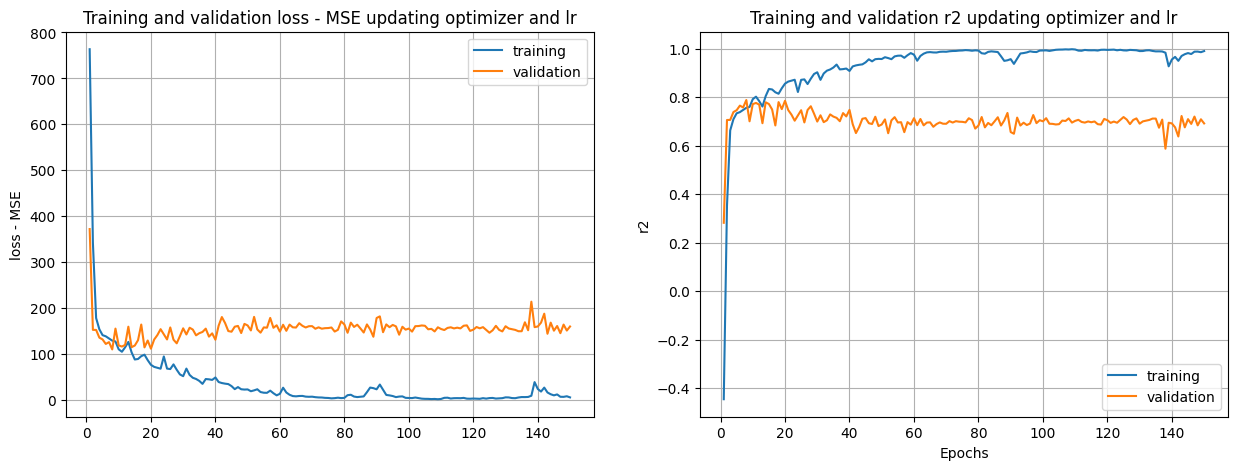

In [41]:
# visualize
chosenLr = grid_result_lr.best_params_['model__optimizer__learning_rate']
def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate = chosenLr)
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

tf.random.set_seed(seed)
random.seed(seed)
mlp_lr =  create_mlplr()
mlp_lr_hist= mlp_lr.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_lr_hist,'updating optimizer and lr',150)


In [42]:
get_best_epochs(mlp_lr_hist)

Best number of epochs 8


### Drop-out

In [43]:
# Drop oout
def create_mlpdpt(dpt = 0):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(dpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(dpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model
#Buil Learning rate for optimization function
dpt = [0, 0.1,0.2, 0.3, 0.4, 0.5]
epochs = np.arange(0,30)

pams_grid = dict(model__dpt=dpt,
                  epochs = epochs)

# Build model and grid searcg

tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpdpt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_dpt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_dpt = grid_dpt.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_dpt, 'Top results for drop-put rate' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top results for drop-put rate
Best: 0.647659 using {'epochs': 9, 'model__dpt': 0}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
54,"{'epochs': 9, 'model__dpt': 0}",0.796119,0.021797,0.647659,0.021797
92,"{'epochs': 15, 'model__dpt': 0.2}",0.777753,0.013610,0.645334,0.013610
79,"{'epochs': 13, 'model__dpt': 0.1}",0.775781,0.031689,0.644462,0.031689
127,"{'epochs': 21, 'model__dpt': 0.1}",0.825771,0.030200,0.643168,0.030200
62,"{'epochs': 10, 'model__dpt': 0.2}",0.755338,0.010223,0.642101,0.010223
66,"{'epochs': 11, 'model__dpt': 0}",0.826712,0.022691,0.641884,0.022691
72,"{'epochs': 12, 'model__dpt': 0}",0.815935,0.015418,0.639450,0.015418
60,"{'epochs': 10, 'model__dpt': 0}",0.804034,0.024860,0.637716,0.024860
152,"{'epochs': 25, 'model__dpt': 0.2}",0.821037,0.023872,0.636155,0.023872
36,"{'epochs': 6, 'model__dpt': 0}",0.737842,0.021001,0.634869,0.021001


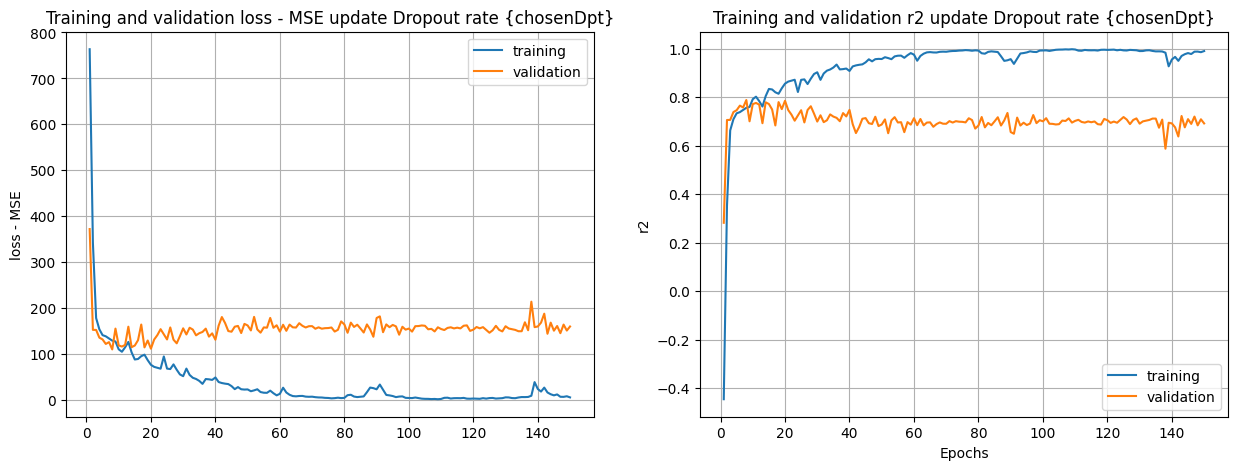

In [44]:
# Visualize
chosenDpt = grid_result_dpt.best_params_['model__dpt']
tf.random.set_seed(seed)
random.seed(seed)
mlp_dpt =  create_mlpdpt(chosenDpt)
mlp_dpt_hist= mlp_dpt.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_dpt_hist,'update Dropout rate {chosenDpt}',150)


### Final model

In [45]:
def create_mlp():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(chosenDpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(chosenDpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model

mlp_final = create_mlp()
mlp_final.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 256)               44800     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_87 (Dense)            (None, 64)              

In [46]:
chosenEp = grid_result_dpt.best_params_['epochs']
tf.random.set_seed(seed)
random.seed(seed)
mlp_final.fit(xtrain, ytrain,
               epochs=chosenEp,
               batch_size=chosenBatch,
               verbose=0,)


In [47]:
test_lost_score, test_r2_score = mlp_final.evaluate(xtest, ytest)
test_pred = mlp_final.predict(xtest)

4/4 [==============================] - 0s 1ms/step


MSE in testing: 156.50958251953125, 
R2 in testing: 0.7144218683242798,
MAE in testing: 8.718577595055102, 
Precision of 10%: 0.4230769230769231


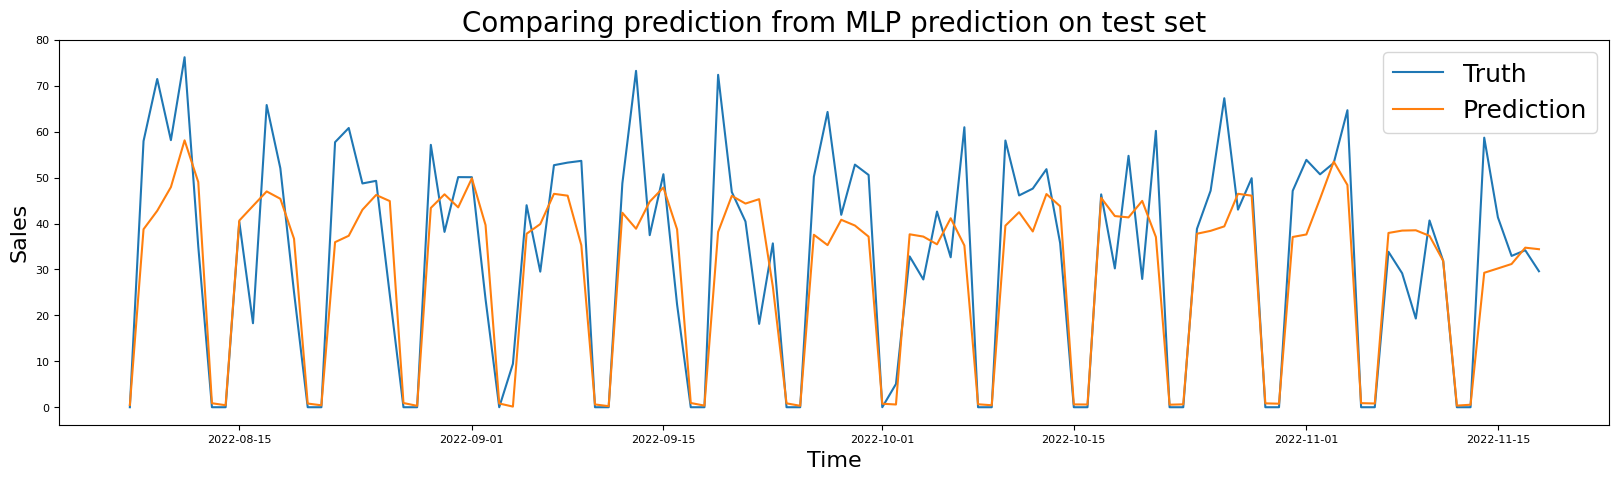

In [48]:

mae =  mean_absolute_error(ytest, test_pred)
pre = get_pre(ytest, test_pred, 0.1)

print(f'MSE in testing: {test_lost_score}, \nR2 in testing: {test_r2_score},\nMAE in testing: {mae}, \nPrecision of 10%: {pre}')

plotprediction(ytest_df, test_pred.flatten(), 'MLP prediction on test set')